In [1]:
## imports
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn  
import torch.optim as optim
from scipy.interpolate import BarycentricInterpolator
import scipy
import seaborn as sns
from sklearn.model_selection import ParameterGrid
from torch.optim.lr_scheduler import StepLR
from torch.optim.lr_scheduler import ExponentialLR
from torch.utils.data import DataLoader, TensorDataset
import time
import json
import os

# Test of Neural Copula training

## Defining classes

### marginal class

In [2]:
class MarginalModel(nn.Module):
    def __init__(self, device, num_layers=5, num_neurons=5, lr=0.01):
        super(MarginalModel, self).__init__()

        # Model specification
        layers = [nn.Linear(1, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())

        self.fc = nn.Sequential(*layers)
        self.optimizer = optim.Adam(self.parameters(), lr=lr)
        self.batch_size = 128

        # Data for training
        self.ObservedData = None
        self.uniform_data = torch.tensor(np.linspace(0, 1, 500), dtype=torch.float32).view(-1, 1)
        self.lower_bound = torch.tensor([[0.0]]).to(device)
        self.upper_bound = torch.tensor([[1.0]]).to(device)

        ## For sampling
        self.domainUpper = torch.tensor([[1.0]]).to(device)
        self.domainLower= torch.tensor([[0.0]]).to(device)
        self.inverted = False
        self.inverseInterpolator = None

    def forward(self, x):
        return self.fc(x)

    def loss_function(self, x):
        x = x.detach().requires_grad_()
        self.uniform_data= self.uniform_data.detach().requires_grad_()
        y_pred = self(x)
        y_pred_uniform = self(self.uniform_data)
        dydx = torch.autograd.grad(y_pred, x, torch.ones_like(y_pred), create_graph=True)[0]
        dydx_uniform = torch.autograd.grad(y_pred_uniform, self.uniform_data, torch.ones_like(y_pred_uniform), create_graph=True)[0]

        L1 = -torch.mean(torch.log(torch.relu(dydx) + 1e-8))
        L2 = torch.mean(torch.relu(-dydx_uniform))
        L3 = torch.abs(1 - torch.sum(dydx_uniform)/self.uniform_data.shape[0])
        L4 = self(self.lower_bound) + torch.abs(1 - self(self.upper_bound))
        Loss = L1*0.001 + L2 + L3 +  L4
        return Loss , L1, L2, L3, L4


    def train_model(self, X, epochs=5000, log_interval=500):
        self.ObservedData = X

        # dataset = torch.utils.data.TensorDataset(X)
        # data_loader = torch.utils.data.DataLoader(dataset, batch_size=self.batch_size, shuffle=True)
        for epoch in range(epochs):
            #for batch_idx, (data,) in enumerate(data_loader):
                
            self.optimizer.zero_grad()
            loss, L1, L2, L3, L4 = self.loss_function(X)
            loss.backward()
            self.optimizer.step()

            if epoch % log_interval == 0:
                print(f'Epoch {epoch}, Loss: {loss.item()}, Constraint losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}')

    def newSamples(self, ProbabilityValues = None, n = 1000): 
        # Sampling method that replaces the interpolator which struggles with values close to 0 and 1
        if ProbabilityValues is None:
            ProbabilityValues = np.random.uniform(0, 1, n)
        if torch.is_tensor(ProbabilityValues) == False:
            ProbabilityValues = torch.tensor(ProbabilityValues, dtype=torch.float32).view(-1, 1)
        sampledData = self._vectorized_bisection(ProbabilityValues).detach().numpy()
        return sampledData

    # def sample(self, n = 1000, ProbabilityValues = None): # Can sample only from marginal and with given probability values
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True

    #     if ProbabilityValues is None:
    #         ProbabilityValues = np.random.uniform(0, 1, n)
            
    #     # Generate random samples from a uniform distribution
    #     sampledData = self.inverseInterpolator(ProbabilityValues)
    #     return sampledData

    # def _invertModel(self, asTensor=True, plot=False):
    #     # Invert the model to get inverse CDF function
    #     rangeUpper = self(self.domainUpper)
    #     rangeLower= self(self.domainLower)
    #     # Generate Chebyshev nodes
    #     n = 3000
    #     rangePoints = self._chebyshev_nodes(n, rangeLower, rangeUpper).view(-1, 1)

    #     # use nodes to find inverses
    #     domainPoints = self._vectorized_bisection(rangePoints)

    #     # Add boundary points
    #     rangePoints = torch.cat((torch.tensor([0.0]), rangePoints.squeeze(), torch.tensor([1.0])))
    #     domainPoints = torch.cat((torch.tensor([0.0]), domainPoints.squeeze(), torch.tensor([1.0])))
    #     rangePoints_np = rangePoints.numpy()
    #     domainPoints_np = domainPoints.numpy()

    #     # Create interpolator
    #     interpolant = BarycentricInterpolator(rangePoints_np, domainPoints_np)
    #     interpolantTensor = lambda x: self._tensor_interpolant(x, interpolant) # interpolant using PyTorch tensors

    #     if plot:
    #         self.plotModel(model = interpolantTensor)
    #     if asTensor:
    #         return interpolantTensor
    #     else:
    #         return interpolant
        
    # def _tensor_interpolant(self, p_tensor, interpolant):
    #     """Interpolant function that takes PyTorch tensors as input."""
    #     p_numpy = p_tensor.detach().cpu().numpy()
    #     x_numpy = interpolant(p_numpy)
    #     return torch.tensor(x_numpy, dtype=torch.float32)

    def PlotModel(self):
        trainingData = self.ObservedData.detach().numpy()

        # # Generate x values for plotting
        x_points = np.linspace(0, 1, 100)
        x_plot =torch.tensor(x_points, dtype=torch.float32).view(-1, 1)
        x_plot.requires_grad = True  # Enable gradients for x_plot
        y_pred = self(x_plot)  # Keep y_pred in computation graph
        pdfPred = torch.autograd.grad(y_pred, x_plot, torch.ones_like(y_pred), create_graph=True)[0]

        ### Convert to numpy for plotting
        y_vals = y_pred.detach().numpy()
        grad_vals = pdfPred.detach().numpy()

        ### Plot the neural network approximation
        plt.plot(x_points, y_vals, label='CDF approximation', linestyle='dashed')
        ### Plot the derivative
        plt.plot(x_points, grad_vals, label="PDF Approximation", linestyle='solid')
        plt.hist(trainingData, bins=1000, density=True, alpha=0.6, label='True Distribution of data');
        plt.legend()
        plt.xlabel('x')
        plt.ylabel('Density')
        plt.title('Neural Network Approximation of PDF and CDF ')
        plt.show()

    # def PlotInverse(self):
    #     if self.inverted == False:
    #         print("Model not inverted. Inverting model...")
    #         self.inverseInterpolator = self._invertModel(asTensor=False)
    #         self.inverted = True    
        
    #     x_points = np.linspace(0, 1, 1000)
    #     y_pred = self.inverseInterpolator(x_points)  
    #     #ChebyshovPoints = self._chebyshev_nodes(3000, 0, 1).numpy()
    #     plt.plot(x_points, y_pred, color='blue', label='Inverse CDF approximation')  # Blue line
    #     #plt.scatter(ChebyshovPoints, self.inverseInterpolator(ChebyshovPoints), color='red', label='Chebyshev nodes')  # Red points
    #     plt.xlabel('x')
    #     plt.ylabel('Inverse CDF')
    #     plt.title('Inverse CDF Approximation')
    #     plt.legend()
    #     plt.show()
        
    # def _chebyshev_nodes(self, n, a, b):
    #     """Generate n Chebyshev nodes in the interval [a, b]."""
    #     return torch.tensor([0.5 * (a + b) + 0.5 * (b - a) * np.cos((2 * k + 1) * np.pi / (2 * n)) for k in range(n)], dtype=torch.float32)

    def _vectorized_bisection(self, y, tol=1e-6, max_iter=100):
        """
        Vectorized Bisection Method to find roots of a function f(y) in the interval [0,1] for multiple values of y simultaneously.
        
        Parameters:
        f : function
            The function whose roots are to be found.
        y : torch.Tensor
            Tensor of values for which roots are to be found.
        tol : float, optional
            The tolerance for stopping the iteration (default is 1e-6).
        max_iter : int, optional
            Maximum number of iterations (default is 100).
        
        Returns:
        torch.Tensor
            Tensor of estimated root values.
        """
        a, b = torch.zeros_like(y), torch.ones_like(y)
        fa, fb = self(a) , self(b) 
        fa, fb = fa - y, fb - y
        
        for _ in range(max_iter):
            c = (a + b) / 2  # Midpoint
            fc = self(c) - y
            left_mask = fc * fa < 0
            right_mask = fc * fb < 0
            a, b = torch.where(left_mask, a, c), torch.where(right_mask, b, c)
            if torch.all(torch.abs(b - a) < tol):
                break
        return (a + b) / 2



### copula class

In [3]:

class CopulaModel(nn.Module):
    def __init__(self, device, dataPoints, Marginal1, Marginal2, num_layers=5, num_neurons=5, lr=0.01,
                solver = 'sgd', scheduler = None, batch_size = 512 ,boundary_points = 100, uniform_points = 15, lossWeight = np.ones(5)):

        super(CopulaModel, self).__init__()
        dimensions = dataPoints.size(1)
        layers = [nn.Linear(dimensions, num_neurons), nn.Tanh()]  # Input layer
        for _ in range(num_layers - 1):  # Hidden layers
            layers.append(nn.Linear(num_neurons, num_neurons))
            layers.append(nn.Tanh())
        layers.append(nn.Linear(num_neurons, 1))  # Output layer
        layers.append(nn.Sigmoid())
        self.fc = nn.Sequential(*layers)

        ## Optimizer
        if solver == 'sgd':
            self.optimizer = optim.SGD(self.parameters(), lr=lr)
        elif solver == 'adam':
            self.optimizer = optim.Adam(self.parameters(), lr=lr)

        ## Learning rate scheduler
        if scheduler == 'step':
            self.scheduler = StepLR(self.optimizer, step_size=10, gamma=0.1)
        elif scheduler == 'exponential':
            self.scheduler = ExponentialLR(self.optimizer, gamma=0.9)
        else:
            self.scheduler = None
        
        ### Data for training
        self.ObservedData = dataPoints
        self.Marginal1 = Marginal1
        self.Marginal2 = Marginal2

        x1 = self.ObservedData[:,0]
        x2 = self.ObservedData[:,1]
        ProbVals1 = self.Marginal1(x1.view(-1, 1))
        ProbVals2 = self.Marginal2(x2.view(-1, 1))
        self.u = torch.cat((ProbVals1, ProbVals2), dim=1).to(device)

        # Boundary points
        self.upperBoundary = self._generateUpperBoundaryPoints(dimensions, num_points=boundary_points).to(device)
        self.lowerBoundary = self._generateLowerBoundPoints(dimensions, num_points=boundary_points).to(device)
        # Uniform grid points
        u= np.linspace(0.0, 1.0, uniform_points)
        U1, U2 = np.meshgrid(u, u, indexing="ij")
        unitSquarePoints= np.column_stack((U1.ravel(), U2.ravel()))
        self.unitSquaretensor = torch.tensor(unitSquarePoints, dtype=torch.float32).to(device)

        # Look at later
        self.flagSumData = self._FlagSum(self.unitSquaretensor, self.u).to(device)
        self.delta_m = 1 / dataPoints.shape[0]

        # Practicality
        self.batch_size = batch_size
        self.isTrained = False
        self.lossWeight = lossWeight


    def forward(self, x):
        return self.fc(x)

    # def _CopulaGradient(self,x):
    #     x1 = x[:,0]
    #     x2 = x[:,1]
    #     # Probability integral transform
    #     ProbVals1 = self.Marginal1(x1.view(-1, 1))
    #     ProbVals2 = self.Marginal2(x2.view(-1, 1))
    #     u = torch.cat((ProbVals1, ProbVals2), dim=1)
    #     # Calculate marginal densities
    #     gradM1 = torch.autograd.grad(ProbVals1, x1, torch.ones_like(ProbVals1), create_graph=True, allow_unused=True)[0]
    #     gradM2 = torch.autograd.grad(ProbVals2, x2, torch.ones_like(ProbVals2), create_graph=True, allow_unused=True )[0]
    #     # Prediction and gradient of copula CDF
    #     y_pred = self(u)
    #     gradCopulaModel = torch.autograd.grad(y_pred, u, torch.ones_like(y_pred), create_graph=True, allow_unused=True )[0]
    #     #cross_derivative = torch.autograd.grad(outputs=gradCopulaModel[:, 0], inputs=u, grad_outputs=torch.ones_like(gradCopulaModel[:, 0]),retain_graph=True)[0][:, 1]
    #     CopulaGradient = gradCopulaModel[:, 0] * gradM1 * gradCopulaModel[:, 1] * gradM2
    #     #CopulaGradient = cross_derivative * gradM1 * gradM2  
    #     return CopulaGradient
        
    def _CopulaGradient(self, x, AsUnitsquare = False):
        if AsUnitsquare == False:
            x1 = x[:, 0]
            x2 = x[:, 1]
            
            # Compute PIT-transformed inputs
            ProbVals1 = self.Marginal1(x1.view(-1, 1))
            ProbVals2 = self.Marginal2(x2.view(-1, 1))
            u = torch.cat((ProbVals1, ProbVals2), dim=1)
            
            # Marginal densities: f1(x1), f2(x2)
            # gradM1 = torch.autograd.grad(ProbVals1, x1, torch.ones_like(ProbVals1), create_graph=True)[0]
            # gradM2 = torch.autograd.grad(ProbVals2, x2, torch.ones_like(ProbVals2), create_graph=True)[0]
            
        else:
            u = x
            # x1 = torch.tensor(self.Marginal1.newSamples(ProbabilityValues = x[:, 0].detach().numpy()))
            # x2 = torch.tensor(self.Marginal2.newSamples(ProbabilityValues = x[:, 1].detach().numpy()))
            # x1.requires_grad = True
            # x2.requires_grad = True
            # ProbVals1 = self.Marginal1(x1.view(-1, 1))
            # ProbVals2 = self.Marginal2(x2.view(-1, 1))
            # # Marginal densities: f1(x1), f2(x2)
            # gradM1 = torch.autograd.grad(ProbVals1, x1, torch.ones_like(ProbVals1), create_graph=True)[0]
            # gradM2 = torch.autograd.grad(ProbVals2, x2, torch.ones_like(ProbVals2), create_graph=True)[0]
        # Evaluate model C(u,v)
        y_pred = self(u)

        # First partial: ∂C/∂u
        grad_u = torch.autograd.grad(outputs=y_pred,inputs=u,grad_outputs=torch.ones_like(y_pred),create_graph=True)[0][:, 0]
        # Second partial: ∂²C/∂u∂v
        grad_uv = torch.autograd.grad(outputs=grad_u,inputs=u,grad_outputs=torch.ones_like(grad_u),create_graph=True)[0][:, 1]

        # Combine to form full joint density
        #joint_density = grad_uv * gradM1 * gradM2
        return grad_uv

    # def _HVolume(self, unitsquareTensor):
    #     lowerLeftPoints = unitsquareTensor[(unitsquareTensor[:,0] < 0.999) & (unitsquareTensor[:,1] < 0.999)]
    #     lowerRightPoints = lowerLeftPoints.clone()
    #     upperRightPoints = lowerLeftPoints.clone()
    #     upperLeftPoints = lowerLeftPoints.clone()

    #     lowerRightPoints[:,0] += 0.001 
    #     upperRightPoints += 0.001
    #     upperLeftPoints[:,1] += 0.001 

    #     #print(lowerLeftPoints.shape, lowerRightPoints.shape, upperRightPoints.shape, upperLeftPoints.shape)

    #     Hvolume = self(lowerLeftPoints) - self(lowerRightPoints) + self(upperRightPoints) - self(upperLeftPoints)
    #     return Hvolume

    def Copula_loss_function(self, x): ## MAKE SURE TO PASS IN THE SAME DATAPOINTS AS IN THE INITIALIZATION
        x.requires_grad = True
        self.unitSquaretensor.requires_grad = True
        CopulaGradientObserved = self._CopulaGradient(x)
        n_observed = x.shape[0]
        CopulaGradientUnitSquare = self._CopulaGradient(self.unitSquaretensor, AsUnitsquare=True)  
        n_unitsquare = self.unitSquaretensor.shape[0]
        #flagSumData = self._FlagSum(x, self.unitSquaretensor)
        pred_unitSquare = self(self.unitSquaretensor)

        
        L1 = -torch.mean(torch.log(torch.relu(CopulaGradientObserved) + 1e-8))
        L2 = torch.mean(torch.relu(-CopulaGradientUnitSquare))
        L3 = torch.abs(1 - torch.sum(CopulaGradientUnitSquare / CopulaGradientUnitSquare.shape[0]))
        L4 = torch.sum(self(self.lowerBoundary)) + torch.sum(torch.abs(self(self.upperBoundary) - torch.min(self.upperBoundary, dim=1).values.view(-1,1)))      
        L5 = (1/(n_unitsquare)) * torch.sum(torch.abs(pred_unitSquare.squeeze() - self.flagSumData/n_observed))

        #Hvolume = self._HVolume(self.unitSquaretensor)
        #L5 = torch.mean(torch.relu(-Hvolume))

        Loss =  self.lossWeight[0]*L1 + self.lossWeight[1]*L2 + self.lossWeight[2]*L3 + self.lossWeight[3]*L4 + self.lossWeight[4]*L5
        return Loss, L1, L2, L3, L4, L5
    
    def _generateLowerBoundPoints(self, d, num_points=100):
        grid = np.linspace(0, 1, num_points)
        all_surfaces = []
        for k in range(d):
            grid_points = np.meshgrid(*([grid] * (d - 1)), indexing="ij")
            points = np.stack(grid_points, axis=-1).reshape(-1, d - 1)
            surface_points = np.insert(points, k, 0, axis=1)
            all_surfaces.append(surface_points)
        return torch.tensor(np.vstack(all_surfaces), dtype=torch.float32)

    def _generateUpperBoundaryPoints(self, d, num_points=100):
        oneArray = np.ones((d * num_points, d))
        u = np.linspace(0, 1, num_points)
        for i in range(d):
            oneArray[i * num_points:(i + 1) * num_points, i] = u
        return torch.tensor(oneArray, dtype=torch.float32)
    
    def _flag(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized version of _flag that returns a matrix where each element is a comparison result."""
        return torch.all(y.unsqueeze(0) < x.unsqueeze(1), dim=2).float()

    def _FlagSum(self, x: torch.Tensor, y: torch.Tensor) -> torch.Tensor:
        """Vectorized computation of FlagSum without explicit Python loops."""
        return self._flag(x, y).sum(dim=1)

    def train_model(self, X, epochs=5000, log_interval=500):
            dataset = TensorDataset(X)
            dataloader = DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

            for epoch in range(epochs):
                for batch in dataloader:
                    batch_X = batch[0]  # since TensorDataset returns a tuple

                    self.optimizer.zero_grad()
                    loss, L1, L2, L3, L4, L5 = self.Copula_loss_function(batch_X)
                    loss.backward()
                    self.optimizer.step()

                if epoch % log_interval == 0:
                    print(f'Epoch {epoch}, Loss: {loss.item()}, Losses: L1: {L1.item()}, L2: {L2.item()}, L3: {L3.item()}, L4: {L4.item()}, L5: {L5.item()}')

                if self.scheduler:
                    self.scheduler.step()

            self.isTrained = True  # Set the flag to indicate that the model has been trained  

    def sample(self, n=1000):
            if not self.isTrained:
                print("Model not trained. Training model...")
                self.train_model(self.ObservedData)
            # Build the grid to compute M
            dim_range = torch.linspace(0, 1, 1000)
            grid = torch.stack(torch.meshgrid(dim_range, dim_range, indexing='ij'), dim=-1).flatten(0, 1).requires_grad_()
            C_uv = self(grid)
            grad_u = torch.autograd.grad(C_uv, grid, torch.ones_like(C_uv), create_graph=True)[0][:, 0]
            grad_uv = torch.autograd.grad(grad_u, grid, torch.ones_like(grad_u), create_graph=True)[0][:, 1]
            M = grad_uv.max().item()

            # Initialize empty list to collect samples
            accepted_samples = []
            total_accepted = 0

            # While not enough samples
            while total_accepted < n:
                # Propose candidates
                batch_size = 1*n  
                u1 = torch.rand(batch_size, 1)
                u2 = torch.rand(batch_size, 1)
                u = torch.cat((u1, u2), dim=1).requires_grad_(True)

                # Forward pass
                y_pred = self(u)
                grad_u1 = torch.autograd.grad(y_pred, u, torch.ones_like(y_pred), create_graph=True)[0][:, 0]
                grad_u1_u2 = torch.autograd.grad(grad_u1, u, torch.ones_like(grad_u1), create_graph=True)[0][:, 1]
                acceptance_prob = grad_u1_u2 / M
                random_uniform = torch.rand_like(acceptance_prob)
                accepted_batch = u[random_uniform <= acceptance_prob]


                total_accepted += accepted_batch.shape[0]
                print(f'Accepted: {total_accepted}')
                accepted_samples.append(accepted_batch)

            # Concatenate all accepted batches
            accepted_samples = torch.cat(accepted_samples, dim=0)

            # Only keep exactly n samples
            accepted_samples = accepted_samples[:n]
            return accepted_samples
    
    def plotSamples(self, sample, ProbSpace = True):
        df_samples = pd.DataFrame({
        "U1": sample[:,0].flatten(),  
        "U2": sample[:,1].flatten()
        })
        sns.jointplot(
            data=df_samples, x="U1", y="U2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )
        if ProbSpace:
            plt.suptitle("Sampled data in probability space", y=1.02);  
        else:
            plt.suptitle("Sampled data in return space", y=1.02);
        plt.show()
        pass




### neural copula

In [4]:
class NeuralCopula():
    def __init__(self, data, params):
        self.num_layers = params['num_layers']
        self.num_neurons = params['num_neurons']
        self.lr = params['lr']
        self.scheduler = params['scheduler']
        self.solver = params['solver']
        self.epochs = params['epochs']
        self.batch_size = params['batch_size']
        self.uniform_points = params['uniform_points']
        self.boundary_points = params['boundary_points']
        self.LossWeights = np.array([params['L1_weight'], params['L2_weight'], params['L3_weight'], params['L4_weight'], params['L5_weight']])

        
        self.Marginal1 = None
        self.Marginal2 = None
        self.Copula = None
        self.initialCopulaWeights = None
        self.SetInitialWeights = None
        self.copulaTrainingTime = None
        self.data = data
        self.normalizedData = None
        self.normalizedDataAsTensor = None
        self.isNormalized = False

        ## Normalization variables
        self.scaling = 2.0
        self.M1_upper = None
        self.M1_lower = None
        self.M2_upper = None
        self.M2_lower = None

        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        print(f"{self.device} is used to train model")

    def normalizeData(self,scaling=2.0):
        scaling = 2.0
        n = self.data.shape[0]
        d = self.data.shape[1]

        self.M1_upper = scaling * np.max(self.data[:,0])
        self.M1_lower = scaling * np.min(self.data[:,0])
        self.M2_upper = scaling * np.max(self.data[:,1])
        self.M2_lower = scaling * np.min(self.data[:,1])

        M1boundaryPoints =  np.array([self.M1_upper, self.M1_lower]) # Creates points for bounds of what the data generated can be
        M2boundaryPoints =  np.array([self.M2_upper, self.M2_lower]) # Creates points for bounds of what the data generated can be
        extendedData = np.zeros((n+2, d))
        extendedData[:,0] = np.concatenate((self.data[:,0], M1boundaryPoints)) # Adding boundary points to the data
        extendedData[:,1] = np.concatenate((self.data[:,1], M2boundaryPoints))
        self.normalizedData= (extendedData - np.min(extendedData,axis=0)) / (np.max(extendedData,axis=0) - np.min(extendedData,axis=0))
        self.normalizedDataAsTensor = torch.tensor(self.normalizedData, dtype=torch.float32).to(self.device)
        self.isNormalized = True
        pass

    def denormalizeData(self,NormalizedData):
        DeNormalizedData = NormalizedData * (np.max(self.data, axis=0) - np.min(self.data, axis=0)) + np.min(self.data, axis=0)
        return DeNormalizedData

    def fitModel(self, method = 'regular'):

        ## Training marginals
        self.Marginal1 = MarginalModel(device = self.device, num_layers=6, num_neurons=10, lr=0.01).to(self.device)
        self.Marginal2 = MarginalModel(device = self.device, num_layers=6, num_neurons=10, lr=0.01).to(self.device)
        print('---------------------------------------------------------------------')
        print('Marginal Model 1 Training')
        self.Marginal1.train_model(self.normalizedDataAsTensor[:-2,0].view(-1, 1) , epochs=1500, log_interval=500)
        print('---------------------------------------------------------------------')
        print('Marginal Model 2 Training')
        self.Marginal2.train_model(self.normalizedDataAsTensor[:-2,1].view(-1, 1) , epochs=1500, log_interval=500)
        ## Training copula
        self.Copula = CopulaModel(self.device, self.normalizedDataAsTensor[:-2], self.Marginal1, self.Marginal2, num_layers=self.num_layers, num_neurons=self.num_neurons, lr=self.lr, solver=self.solver, scheduler=self.scheduler, batch_size=self.batch_size, boundary_points=self.boundary_points, uniform_points=self.uniform_points, lossWeight = self.LossWeights).to(self.device)
        if self.SetInitialWeights is not None:
            self.Copula.load_state_dict(self.SetInitialWeights)

        self.initialCopulaWeights = self.Copula.state_dict()
        print('---------------------------------------------------------------------')
        print('Training copula model')
        start_time = time.time()
        self.Copula.train_model(self.normalizedDataAsTensor[:-2], epochs=self.epochs, log_interval=500)
        self.copulaTrainingTime = time.time() - start_time
        print('Training done')
        pass

    def sample(self, Plot = False, n=1000):
        copulaSample = self.Copula.sample(n)
        marginalSamples = self.sample_marginals(copulaSample)
        denormalizedSamples = self.denormalizeData(marginalSamples)
        if Plot:
            self.Copula.plotSamples(copulaSample, ProbSpace = True)
            self.Copula.plotSamples(denormalizedSamples, ProbSpace = False)
        return denormalizedSamples

    def sample_marginals(self,probabilityValues, n=1000):
        sample_marginal1 = self.Marginal1.newSamples(ProbabilityValues=probabilityValues[:,0])
        sample_marginal2 = self.Marginal2.newSamples(ProbabilityValues=probabilityValues[:,1])
        samples = np.column_stack((sample_marginal1, sample_marginal2))
        return samples

    def sample_copula(self, Plot = False, n = 1000):
        copulaSample = self.Copula.sample(n)
        if Plot:
            self.Copula.plotSamples(copulaSample, ProbSpace = True)
        return copulaSample
    

### nc validator

In [5]:
class NC_validator():
    def __init__(self, NeuralCopula):
        self.NC = NeuralCopula
        self.Marginal1 = NeuralCopula.Marginal1
        self.Marginal2 = NeuralCopula.Marginal2
        self.Copula = NeuralCopula.Copula
        self.normalizedDataASTensor = NeuralCopula.normalizedDataAsTensor
        

    def validate(self):
        print('Marginal model validation')
        self._validateMarginals()
        print('Copula model validation')
        self._validateCopula()
        pass

    def _validateMarginals(self): 
        ## Plot the marginal models
        plt.fisize=(3, 3)
        print('Maginal model 1')
        self.Marginal1.PlotModel()
        print('Maginal model 2')
        self.Marginal2.PlotModel()

        # ## Plot inverses of models to check if they are correct
        # print('Maginal model 1')
        # self.Marginal1.PlotInverse()
        # print('Maginal model 2')
        # self.Marginal2.PlotInverse()

        ## Plot sampled data from the models
        Marginal1_samples = self.Marginal1.newSamples(n = 5000)
        Marginal2_samples = self.Marginal2.newSamples(n = 5000)

        x = np.linspace(0, 1, 100)
        x_tensor = torch.tensor(x, dtype=torch.float32).view(-1, 1)
        x_tensor.requires_grad = True

        y_pred1 = self.Marginal1(x_tensor)
        dydx1 = torch.autograd.grad(y_pred1, x_tensor, torch.ones_like(y_pred1), create_graph=True)[0]
        plt.hist(Marginal1_samples, bins=100, density=True, alpha=1, label='Model 1 samples')
        plt.plot(x, dydx1.detach().numpy(), label='Fitted distribution', color='red')
        plt.xlim(0, 1)
        plt.legend()
        plt.show()

        y_pred2 = self.Marginal2(x_tensor)
        dydx2 = torch.autograd.grad(y_pred2, x_tensor, torch.ones_like(y_pred2), create_graph=True)[0]
        plt.hist(Marginal2_samples, bins=100, density=True, alpha=1, label='Model 2 samples')
        plt.plot(x, dydx2.detach().numpy(), label='Fitted distribution', color='red')
        plt.xlim(0, 1)
        plt.legend()
        plt.show()

        ## Plot initial data
        OriginalMarginal1 = self.normalizedDataASTensor[:-2,0].view(-1, 1).detach().numpy()
        OriginalMarginal2 = self.normalizedDataASTensor[:-2,1].view(-1, 1).detach().numpy()

        df_returnSpace = pd.DataFrame({
            "X1": OriginalMarginal1.flatten(),  
            "X2": OriginalMarginal2.flatten()
        })
        sns.jointplot(
            data=df_returnSpace, x="X1", y="X2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )

        # Plot Transformed data
        TransformedMarginal1 = self.Marginal1(self.normalizedDataASTensor[:-2,0].view(-1, 1)).detach().numpy()
        TransformedMarginal2 = self.Marginal2(self.normalizedDataASTensor[:-2,1].view(-1, 1)).detach().numpy()

        df_probabilitySpace = pd.DataFrame({
            "U1": TransformedMarginal1.flatten(),  # Flatten in case of (N,1) shape
            "U2": TransformedMarginal2.flatten()
        })
        plt.suptitle("Original data in return space", y=1.02);

        # Plot the jointplot
        sns.jointplot(
            data=df_probabilitySpace, x="U1", y="U2", kind="scatter",
            marginal_kws=dict(bins=30, fill=True),
            joint_kws={"s": 10, "edgecolor": "none"}  # Removes white outline
        )
        plt.suptitle("Data when transformed to probability space", y=1.02);
        pass


    def _validateCopula(self):
        # Create meshgrid
        u1 = np.linspace(0, 1, 100)
        u2 = np.linspace(0, 1, 100)
        U1, U2 = np.meshgrid(u1, u2, indexing="ij")
        grid = np.column_stack((U1.ravel(), U2.ravel()))
        grid_tensor = torch.tensor(grid, dtype=torch.float32)

        # Get model predictions
        self.Copula.eval()
        with torch.no_grad():
            predictions = self.Copula(grid_tensor)
        Z = predictions.numpy().reshape(100, 100)  

        # Plot
        fig = plt.figure(figsize=(8, 6))
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_surface(U1, U2, Z, cmap="viridis")
        ax.set_xlabel("u1")
        ax.set_ylabel("u2")
        ax.set_zlabel("C(u1, u2)")
        ax.set_title("Fitted Model Surface")
        ax.view_init(elev=15, azim=256)
        plt.show()

        print('Is the model 2-increasing?')
        resultCol = Z[:, 1:] >= Z[:, :-1]
        resultRow = Z[1:, :] >= Z[:-1, :]
        has_false_col = np.any(resultCol == False)
        has_false_row = np.any(resultRow == False)
        print("Any False in resultCol?", has_false_col)
        print("Any False in resultRow?", has_false_row)

        if has_false_col or has_false_row:
            print("Model is not 2-increasing")
            # Find indexes where the result is False
            falseColIdx = np.where(resultCol == False)  # Indices in column-wise comparison
            falseRowIdx = np.where(resultRow == False)  # Indices in row-wise comparison

            # Adjust indices for full matrix (since resultCol and resultRow have reduced dimensions)
            falseColIdx = (falseColIdx[0], falseColIdx[1] + 1)  # Shift column indices to match original Z
            falseRowIdx = (falseRowIdx[0] + 1, falseRowIdx[1])  # Shift row indices to match original Z

            # Combine results if needed
            falseIdx = list(zip(*falseColIdx)) + list(zip(*falseRowIdx))

            print("Indices where False in column-wise comparison:", list(zip(*falseColIdx)))
            print("Indices where False in row-wise comparison:", list(zip(*falseRowIdx)))
            print("All False indices:", falseIdx)
        pass

## Testing code

In [26]:
class DatasetTester():
    def __init__(self, datasets, grid, runs = 1 ):
        self.datasets = datasets
        self.grid = grid
        self.runs = runs
        self.resultDict = {}
        self.isTrained = False
        self.LossDict = {}

    def runTest(self):
        for name, data in self.datasets.items():
            # Creating ProgressLogger
            file_path = 'Results_' + name + '.json'
            #logger = ProgressLogger(file_path=file_path)

            print(f'######################### Running test with dataset: {name} ###########')
            Mtester = MethodTester(data=data, grid = self.grid, runs = 1)
            Mtester.runTest()
            self.resultDict[name] = Mtester

        self.isTrained = True
        pass

    def evaluateResults(self):
        print('############################ Result printout ##############################')
        DatasetsKeys = list(self.resultDict.keys())
        ModelKeys = list(self.resultDict[DatasetsKeys[0]].resultDict.keys())

        for modelKey in ModelKeys:
            Loss = 0
            trainingTime = 0
            constraintLoss = 0
            for dataKey in DatasetsKeys:
                constraintLoss += self.resultDict[dataKey].resultDict[modelKey].L2 +self.resultDict[dataKey].resultDict[modelKey].L3 +self.resultDict[dataKey].resultDict[modelKey].L4 + self.resultDict[dataKey].resultDict[modelKey].L5
                Loss += self.resultDict[dataKey].resultDict[modelKey].L1 +self.resultDict[dataKey].resultDict[modelKey].L2 +self.resultDict[dataKey].resultDict[modelKey].L3 + self.resultDict[dataKey].resultDict[modelKey].L4 + self.resultDict[dataKey].resultDict[modelKey].L5
                trainingTime += self.resultDict[dataKey].resultDict[modelKey].copulaTrainingTime
                
            print('----------------------------------------------------------------------------')
            print(f'Model: {modelKey} ')
            print(f'Total loss: {Loss}')
            print(f'Average training time of copula model: {trainingTime/len(DatasetsKeys)} seconds') 
            print(f'Constraint loss: {constraintLoss}')
            self.LossDict[modelKey] = Loss 
        print('###########################################################################')

class MethodTester():
    def __init__(self, data, grid, runs = 1, logger = None):
        self.logger = logger
        self.data = data
        self.grid = grid
        self.runs = runs
        self.resultDict = {}


    def runTest(self):
        for params in ParameterGrid(self.grid):
            print(f"Running test with options: {params}")
            ## Regular training
            print('Regular training')
            self._trainRegular(params)
            print('----------------------------------------------------------------------------')

    def _trainRegular(self, params):
        testerList = []
        for run in range(self.runs):
            ## Set random seed for reproducibility (maybe)
            print(f"Run {run+1} of {self.runs}")
            tester = ParameterTester(self.data, params)
            tester.runTest()
            testerList.append(tester)

        ## Inspect model results and choose best
        #testerLosses = [tester.finalLoss.item()  for tester in testerList]   ## make this unweighted losses
        testerLosses = [tester.L1.item() + tester.L2.item() + tester.L3.item() + tester.L4.item() + tester.L5.item()  for tester in testerList]   ## make this unweighted losses

        ## store model with smallest loss 
        bestTester = testerList[np.argmin(testerLosses)] ## [testerConstraintLosses < 0.01]
        key = frozenset(params.items())
        TrainingData = {"L1": bestTester.L1.item(), "L2": bestTester.L2.item(), "L3": bestTester.L3.item(), "L4": bestTester.L4.item(), "L5": bestTester.L5.item(), "time":bestTester.trainingTime}

        if self.logger is not None:
            # Now you can call `logger.add_run()` anywhere in your program
            key_json = "__".join(f"{k}={v}" for k, v in sorted(params.items()))

            self.logger.add_run(key_json, TrainingData)

        self.resultDict[key] = bestTester
        

class ParameterTester():
    def __init__(self, data, parameters, initialWeights = None):
        #self.data = data
        self.NC = NeuralCopula(data, parameters)
        self.NC.SetInitialWeights = initialWeights

        self.NC.normalizeData()
        self.initialWeights = None
        self.finalWeights = None
        self.finalLoss = None
        self.L1 = None
        self.L2 = None 
        self.L3 = None
        self.L4 = None
        self.L5 = None
        self.trainingTime = None
        
    def runTest(self, method = 'regular'):
        if method == 'regular':
            self.NC.fitModel()

        self.copulaTrainingTime = self.NC.copulaTrainingTime
        self.finalLoss, self.L1, self.L2, self.L3, self.L4, self.L5 = self.NC.Copula.Copula_loss_function(self.NC.normalizedDataAsTensor[:-2])
        self.initialWeights = self.NC.initialCopulaWeights
        self.finalWeights = self.NC.Copula.state_dict()
        self.trainingTime = self.NC.copulaTrainingTime

class ProgressLogger:
    def __init__(self, file_path):
        self.file_path = file_path

    def add_run(self, run_id, run_data):
        data = self._load()
        data[run_id] = run_data
        self._save(data)

    def _load(self):
        if os.path.exists(self.file_path):
            try:
                with open(self.file_path, 'r') as f:
                    return json.load(f)
            except json.JSONDecodeError:
                return {}
        return {}

    def _save(self, data):
        with open(self.file_path, 'w') as f:
            json.dump(data, f, indent=4)

## Test

In [44]:
## Generating datasets 
torch.manual_seed(0)
np.random.seed(0)
corrMat = np.array([[1, 0.7], [0.7, 1]])
A = np.linalg.cholesky(corrMat)
Z = np.random.standard_normal((1000, 2))
X = (A @ Z.T).T

corrMatFrechetUpper = np.array([[1, 0.9999], [0.9999, 1]])
corrMatFrechetLower = np.array([[1, -0.9999], [-0.9999, 1]])
A_U = np.linalg.cholesky(corrMatFrechetUpper)
A_L = np.linalg.cholesky(corrMatFrechetLower)
X_U = (A_U @ Z.T).T
X_L = (A_L @ Z.T).T
X_neg = X.copy()
X_neg[:,1] = -X_neg[:,1]

datasets = {
    'InDepFinal': Z,
    'PosDepFinal': X,
    'NegDepFinal': X_neg,
    'FrecUpFinal' : X_U,
    'FrecLoFinal' : X_L,
}

# grid = {
#     'num_layers': [2, 3, 4],
#     'num_neurons': [5, 10, 15],
#     'lr': [0.1, 0.01, 0.001], 
#     'scheduler': ['step', 'exponential', None],# 'step','exponential'
#     'solver': ['adam', 'sgd'], # 'adam', 'sgd'
#     'epochs': [5000, 10000, 15000],
#     'batch_size': [256, 1024], 
#     'uniform_points': [100], # per dimension really n^2
#     'boundary_points': [100], # per dimension
#     'L1_weight': [1],
#     'L2_weight': [1],
#     'L3_weight': [1],
#     'L4_weight': [1],
#     'L5_weight': [1],
# }

grid = {
    'num_layers': [ 3],
    'num_neurons': [10],
    'lr': [ 0.1], 
    'scheduler': [ 'exponential'],# 'step','exponential'
    'solver': ['adam'], # 'adam', 'sgd'
    'epochs': [10000],
    'batch_size': [2048], 
    'uniform_points': [50], # per dimension really n^2
    'boundary_points': [50], # per dimension
    'L1_weight': [1],
    'L2_weight': [2],
    'L3_weight': [0.5],
    'L4_weight': [1],
    'L5_weight': [1],
}

DataTester = DatasetTester(datasets, grid, runs = 1)
DataTester.runTest()
DataTester.evaluateResults()

######################### Running test with dataset: InDepFinal ###########
Running test with options: {'L1_weight': 1, 'L2_weight': 2, 'L3_weight': 0.5, 'L4_weight': 1, 'L5_weight': 1, 'batch_size': 2048, 'boundary_points': 50, 'epochs': 10000, 'lr': 0.1, 'num_layers': 3, 'num_neurons': 10, 'scheduler': 'exponential', 'solver': 'adam', 'uniform_points': 50}
Regular training
Run 1 of 1
cpu is used to train model
---------------------------------------------------------------------
Marginal Model 1 Training
Epoch 0, Loss: 2.01789927482605, Constraint losses: L1: 17.613677978515625, L2: 0.00012196644092909992, L3: 1.0000818967819214, L4: 1.0000817775726318
Epoch 500, Loss: 0.0019716036040335894, Constraint losses: L1: -1.0827127695083618, L2: 0.0, L3: 0.002526402473449707, L4: 0.0005279139732010663
Epoch 1000, Loss: 0.0012091752141714096, Constraint losses: L1: -1.1152089834213257, L2: 0.0, L3: 0.0021619796752929688, L4: 0.00016240455443039536
--------------------------------------------

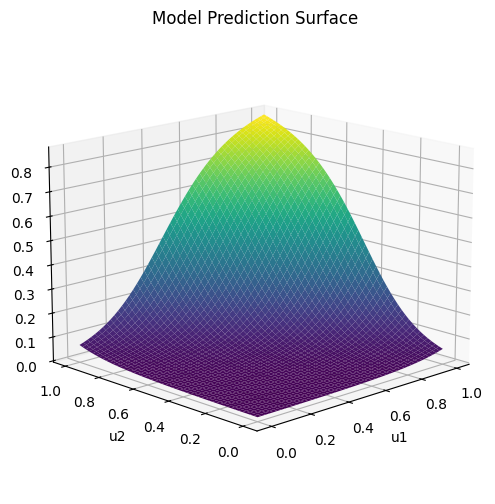

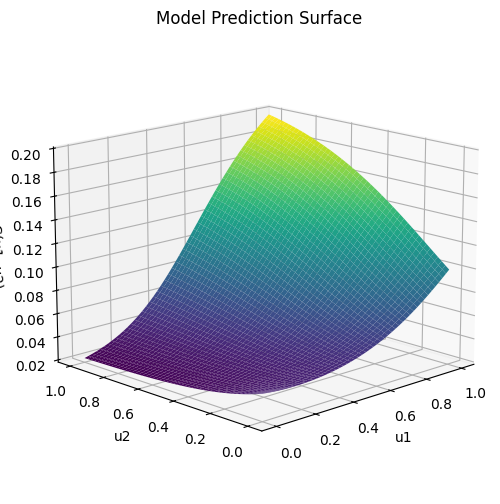

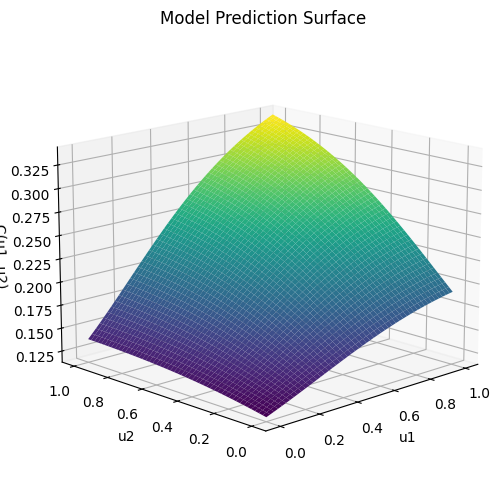

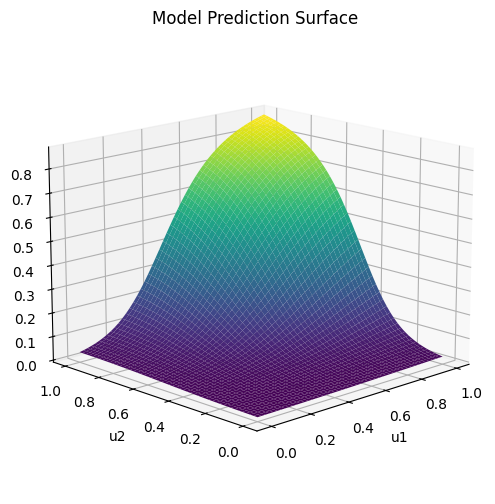

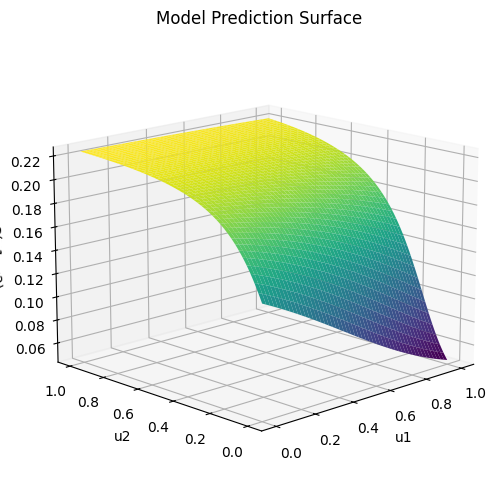

In [45]:
## plot the finished models
def PlotCopulaSurface(copula):
    # Create meshgrid
    u1 = np.linspace(0, 1, 500)
    u2 = np.linspace(0, 1, 500)
    U1, U2 = np.meshgrid(u1, u2, indexing="ij")
    grid = np.column_stack((U1.ravel(), U2.ravel()))
    grid_tensor = torch.tensor(grid, dtype=torch.float32)

    # Get model predictions
    copula.eval()
    with torch.no_grad():
        predictions = copula(grid_tensor)
    Z_pred = predictions.numpy().reshape(500, 500)  

    # Plot
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.plot_surface(U1, U2, Z_pred, cmap="viridis")
    ax.set_xlabel("u1")
    ax.set_ylabel("u2")
    ax.set_zlabel("C(u1, u2)")
    ax.set_title("Model Prediction Surface")
    ax.view_init(elev=15, azim=226)
    plt.show()

DatasetsKeys = list(datasets.keys())

for dataKey in DatasetsKeys:
    MethodTesterKey = list(DataTester.resultDict[dataKey].resultDict.keys())[0]

    PlotCopulaSurface(DataTester.resultDict[dataKey].resultDict[MethodTesterKey].NC.Copula)

# Results from test

## Hyper Parameters

In [10]:
IndependenceTestData = ProgressLogger(file_path="NewResultsMap/Results_InDep.json")._load()
IndepDF = pd.DataFrame.from_dict(IndependenceTestData, orient='index')
IndepDF['TotalLoss'] = IndepDF.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
IndepDF['ConstraintLoss'] = IndepDF.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

PosDepTestData = ProgressLogger(file_path="NewResultsMap/Results_PosDep.json")._load()
PosDepDF = pd.DataFrame.from_dict(PosDepTestData, orient='index')
PosDepDF['TotalLoss'] = PosDepDF.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
PosDepDF['ConstraintLoss'] = PosDepDF.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

NegDepTestData = ProgressLogger(file_path="NewResultsMap/Results_NegDep.json")._load()
NegDepDF = pd.DataFrame.from_dict(NegDepTestData, orient='index')
NegDepDF['TotalLoss'] = NegDepDF.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
NegDepDF['ConstraintLoss'] = NegDepDF.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

UpperFrechetTestData = ProgressLogger(file_path="NewResultsMap/Results_FrecUp.json")._load()
UpperFrechetDF = pd.DataFrame.from_dict(UpperFrechetTestData, orient='index')
UpperFrechetDF['TotalLoss'] = UpperFrechetDF.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
UpperFrechetDF['ConstraintLoss'] = UpperFrechetDF.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

LowerFrechetTestData = ProgressLogger(file_path="NewResultsMap/Results_FrecLo.json")._load()
LowerFrechetDF = pd.DataFrame.from_dict(LowerFrechetTestData, orient='index')
LowerFrechetDF['TotalLoss'] = LowerFrechetDF.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
LowerFrechetDF['ConstraintLoss'] = LowerFrechetDF.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)


In [11]:
rows = list(IndepDF.index) ## Change from indepDf to one of the others when done

# Initialize the new DataFrame with the correct index and columns
resultingDf = pd.DataFrame(index=rows, columns=[
    'Independence', 
    'PositiveDependence', 
    'NegativeDependence', 
    'FrechetUpper', 
    'FrechetLower'
])

# Populate the DataFrame
for rowName in rows:
    resultingDf.loc[rowName, 'Independence'] = IndepDF.loc[rowName, 'TotalLoss']
    resultingDf.loc[rowName, 'PositiveDependence'] = PosDepDF.loc[rowName, 'TotalLoss']
    resultingDf.loc[rowName, 'NegativeDependence'] = NegDepDF.loc[rowName, 'TotalLoss']
    resultingDf.loc[rowName, 'FrechetUpper'] = UpperFrechetDF.loc[rowName, 'TotalLoss']
    resultingDf.loc[rowName, 'FrechetLower'] = LowerFrechetDF.loc[rowName, 'TotalLoss']


In [ ]:
## Computing the loss over the datasets
resultingDf['AverageLoss'] = resultingDf.apply(lambda x: (x['Independence'] + x['PositiveDependence'] + x['NegativeDependence'] 
                                               + x['FrechetUpper'] + x['FrechetLower'])/5, axis=1)

In [ ]:
## Sort the result by average loss over all datasets
resultingDf.sort_values(by='AverageLoss', ascending=True, inplace=True)


In [ ]:
## Save to csv
# resultingDf.to_csv('NewResultsMap/ResultsAllDatasets.csv', index=False)

In [15]:
df = pd.read_csv('NewResultsMap/ResultsAllDatasets.csv')

## Weights

In [21]:
IndependenceTestDataWeights = ProgressLogger(file_path="ResultsWeightTest/Results_InDepWeight.json")._load()
IndepDFWeights = pd.DataFrame.from_dict(IndependenceTestDataWeights, orient='index')
IndepDFWeights['TotalLoss'] = IndepDFWeights.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
IndepDFWeights['ConstraintLoss'] = IndepDFWeights.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

PosDepTestDataWeights = ProgressLogger(file_path="ResultsWeightTest/Results_PosDepWeight.json")._load()
PosDepDFWeights = pd.DataFrame.from_dict(PosDepTestDataWeights, orient='index')
PosDepDFWeights['TotalLoss'] = PosDepDFWeights.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
PosDepDFWeights['ConstraintLoss'] = PosDepDFWeights.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

NegDepTestDataWeights = ProgressLogger(file_path="ResultsWeightTest/Results_NegDepWeight.json")._load()
NegDepDFWeights = pd.DataFrame.from_dict(NegDepTestDataWeights, orient='index')
NegDepDFWeights['TotalLoss'] = NegDepDFWeights.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
NegDepDFWeights['ConstraintLoss'] = NegDepDFWeights.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

UpperFrechetTestDataWeights = ProgressLogger(file_path="ResultsWeightTest/Results_FrecUpWeight.json")._load()
UpperFrechetDFWeights = pd.DataFrame.from_dict(UpperFrechetTestDataWeights, orient='index')
UpperFrechetDFWeights['TotalLoss'] = UpperFrechetDFWeights.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
UpperFrechetDFWeights['ConstraintLoss'] = UpperFrechetDFWeights.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

LowerFrechetTestDataWeights = ProgressLogger(file_path="ResultsWeightTest/Results_FrecLoWeight.json")._load()
LowerFrechetDFWeights = pd.DataFrame.from_dict(LowerFrechetTestDataWeights, orient='index')
LowerFrechetDFWeights['TotalLoss'] = LowerFrechetDFWeights.apply(lambda x: x['L1'] + x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)
LowerFrechetDFWeights['ConstraintLoss'] = LowerFrechetDFWeights.apply(lambda x: x['L2'] + x['L3'] + x['L4'] + x['L5'], axis=1)

In [22]:
rows = list(IndepDFWeights.index) ## Change from indepDf to one of the others when done

# Initialize the new DataFrame with the correct index and columns
resultingDfWeights = pd.DataFrame(index=rows, columns=[
    'Independence', 
    'PositiveDependence', 
    'NegativeDependence', 
    'FrechetUpper', 
    'FrechetLower'
])

# Populate the DataFrame
for rowName in rows:
    resultingDfWeights.loc[rowName, 'Independence'] = IndepDFWeights.loc[rowName, 'TotalLoss']
    resultingDfWeights.loc[rowName, 'PositiveDependence'] = PosDepDFWeights.loc[rowName, 'TotalLoss']
    resultingDfWeights.loc[rowName, 'NegativeDependence'] = NegDepDFWeights.loc[rowName, 'TotalLoss']
    resultingDfWeights.loc[rowName, 'FrechetUpper'] = UpperFrechetDFWeights.loc[rowName, 'TotalLoss']
    resultingDfWeights.loc[rowName, 'FrechetLower'] = LowerFrechetDFWeights.loc[rowName, 'TotalLoss']


In [23]:
## Computing the loss over the datasets
resultingDfWeights['AverageLoss'] = resultingDfWeights.apply(lambda x: (x['Independence'] + x['PositiveDependence'] + x['NegativeDependence'] 
                                               + x['FrechetUpper'] + x['FrechetLower'])/5, axis=1)

In [24]:
## Sort the result by average loss over all datasets
resultingDfWeights.sort_values(by='AverageLoss', ascending=True, inplace=True)


In [25]:
## Save to csv
resultingDfWeights.to_csv('ResultsWeightTest/ResultsAllDatasetsWeights.csv', index=False)

In [ ]:
df_Weights = pd.read_csv('ResultsWeightTest/ResultsAllDatasetsWeights.csv')

## Extracting the results

In [35]:
BestModel = list(resultingDfWeights.index)[0]
LossDfBestModel = pd.DataFrame({
    'Independent': IndepDFWeights.loc[BestModel],
    'PositiveDependence': PosDepDFWeights.loc[BestModel],
    'NegativeDependence': NegDepDFWeights.loc[BestModel],
    'FrechetUpper': UpperFrechetDFWeights.loc[BestModel],
    'FrechetLower': LowerFrechetDFWeights.loc[BestModel],
}).T  # Transpose so strategies become row labels
LossDfNoTimeConstraint = LossDfBestModel.drop(['time', 'ConstraintLoss'], axis=1)

LossDfNoTimeConstraint.to_latex('BestModelLossesNoTimeConstraint.tex', index=True, header=True)